# Segmentación de una imagen por colores

Basado en esta guía [tutorial](https://https://pippython.com/image-segmentation-using-color-spaces-in-opencv-python/). Expandiendo en las explicaciones con teoría vista en la materia de procesamiento de imagenes.

## Imagenes e imports generales

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import hsv_to_rgb
from IPython.display import clear_output


In [ ]:
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo0.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo1.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo2.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo3.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo4.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/nemo5.jpg
!wget https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/bird.jpg
clear_output()

## Espacios de color

Existen diversos espacios de color, entre los cuales encontramos

1. RGB: representación del color descompuesto en rojo, verde y azul y la adicion de estos 3 componentes dan origen al color que queremos.

2. CMYK: representación del color en cian, magenta, amarillo y negro. Podemos ver una imagen

<img src="https://www.softzone.es/app/uploads-softzone.es/2018/08/RGB-CMYK.jpg"></img>

4. HLS: espacio de color descompuesto en hue, lightness y saturation. Esto

<img src="https://docs.microsoft.com/en-us/previous-versions/windows/desktop/wcs/images/hlsline.png"></img>

Observemos todas las conversiones que nos provee openCV

In [ ]:
flags = [i for i in dir(cv2) if i.startswith("COLOR_")]
print(len(flags), "flags total:")
print(flags[40:45])

274 flags total:
['COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_BGR2HSV_FULL', 'COLOR_BGR2LAB']


Carguemos nuestra primera imagen y hagamos una primera observación

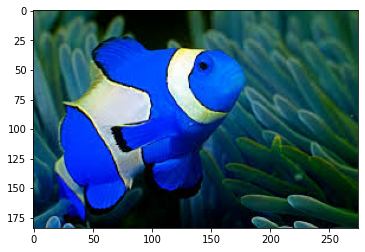

In [ ]:
nemo = cv2.imread("nemo0.jpg")
plt.imshow(nemo)
plt.show()

OpenCV por default utiliza el espacio BGR para cargar una imagen. Es por esto que realizaremos una conversión para pasar a el espacio más comun RGB en el que fue formateada la imagen original

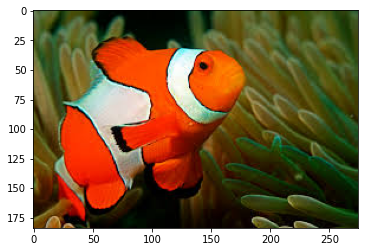

In [ ]:
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
plt.imshow(nemo)
plt.show()

## Visualizaciones en espacios de color

En esta sección la idea es visualizar en difetenes espacios como es la distribución de los colores para la imagen. Esto es un análisis útil si lo que queremos lograr es segementar por colores, ya que pueden haber espacios en donde la distribución da patrones mas segmentables, por ejemplo, agrupando el color rojo en algun sector aislado.

### Espacio RGB

Comencemos viendo la distribución de colores para el espacio RGB

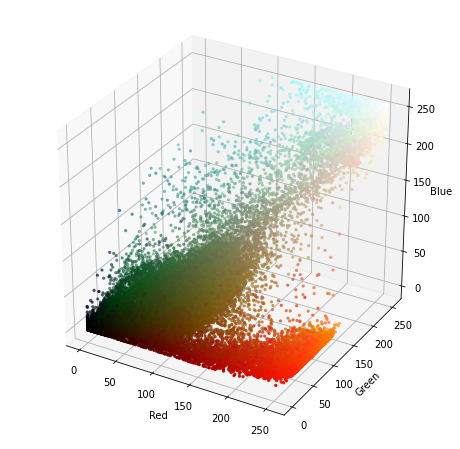

In [ ]:
r, g, b = cv2.split(nemo)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = nemo.reshape((np.shape(nemo)[0] * np.shape(nemo)[1], 3))
norm = colors.Normalize(vmin=-1.0, vmax=1.0)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(
    r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker="."
)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

De este gráfico podemos observar que el color naranja esta muy mezclado con valores rojos y azules, por lo que aislar este color estableciendo rangos de RGB (en este espacio) reulstará difícil.

### Espacio HSV

Veamos ahora la distribución para el espacio HSV (Hue, saturation, brightness)

<img src='https://raw.githubusercontent.com/nicolasdeleon/color-segmentation/master/images/HSV-colorspace.png'>
</img>

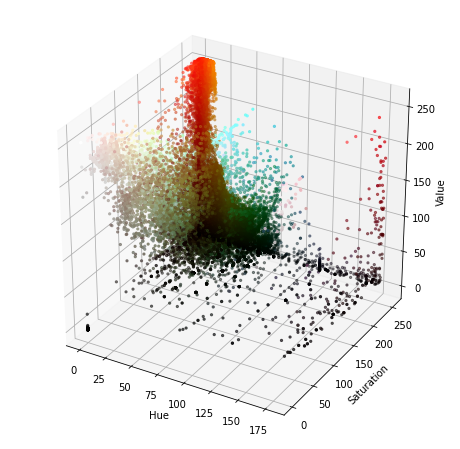

In [ ]:
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_nemo)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(
    h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker="."
)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

En esta representación, los pixeles de color naranja se encuentran mas localizados y separables del resto.

## Rangos para la separación

Como comentamos, utilizaremos el espacio HSV para segmentar cierto color de la imagen. Para esto tendremos que definir un rango de valores que consideraremos que pertenecen al color buscado, estariamos como sectorizando el grafico previamente observado en un cubo menor.

In [ ]:
               #H, S, V
light_orange = (1, 190, 200)
dark_orange = (18, 255, 255)

Observemos estos colores

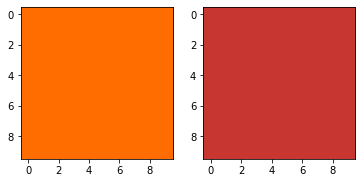

In [ ]:
lo_square = np.full((10, 10, 3), light_orange, dtype=np.uint8) / 255.0
do_square = np.full((10, 10, 3), dark_orange, dtype=np.uint8) / 255.0
plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(do_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(lo_square))
plt.show()

Utilizaremos la función `cv2.inRange` para obtener una **mascara** binaria (1/0) para los colores dentro de nuestro rango pre establecido.

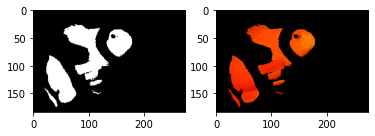

In [ ]:
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)
result = cv2.bitwise_and(nemo, nemo, mask=mask)

plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Con esta máscara y en el espacio HSV pudimos segmentar los colores deseados dando el resultado observado en la figura anterior. Podemos observar que se logró un alto grado de segmentación.

Ahora buscaremos obtener las rayas blancas

Nuevamente definimos nuestro rango para el color blanco

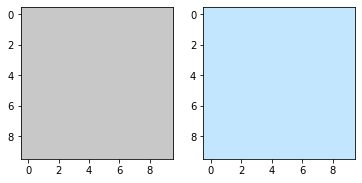

In [ ]:
light_white = (0, 0, 200)
dark_white = (145, 60, 255)

lw_square = np.full((10, 10, 3), light_white, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), dark_white, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()

Ahora apliquemos la mascaras a ver que resultado obtenemos

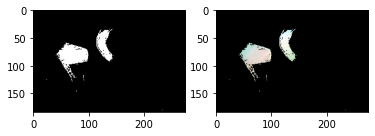

In [ ]:
mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()

Se puede observar una clara separación

Ahora como resultado final de esta secciión, busquemos aplicar ambas mascaras en conjunto para verificar que obtenemos la suma de la imagen para cada mascara aplicada.

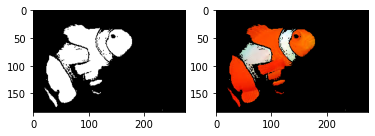

In [ ]:
final_mask = mask + mask_white

final_result = cv2.bitwise_and(nemo, nemo, mask=final_mask)

plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

Para remover o ajustar los bordes entre la segmentación de cada mascara, podemos utilizar un _Blur_ o filtro pasa bajos a la imagen. Utilizaremos un [Gaussian blur](https://https://en.wikipedia.org/wiki/Gaussian_blur#Low-pass_filter)

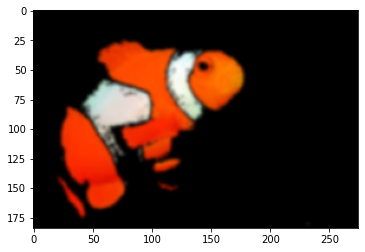

In [ ]:
blur = cv2.GaussianBlur(final_result, (7, 7), 0)
plt.imshow(blur)
plt.show()

Ahi podemos observar una imagen mas limpia sin transiciones tan abruptas entre segmentos

## Generalización

Observemos como resulta esta segmentación para otras imagenes, en donde aparece un pez de la misma especie. Para esto, comenzaremos cargando las imagenes.

In [ ]:
nemos_friends = []
path = 'nemo'
for i in range(6):
    friend = cv2.cvtColor(
        cv2.imread(path + str(i) + ".jpg"), cv2.COLOR_BGR2RGB
    )
    nemos_friends.append(friend)

Creemos una función que permita tomar una imagen y segmentarla con todo lo visto anteriormente.

In [ ]:
def segment_fish(image):
    """ Attempts to segment the clown fish out of the provided image. """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    light_orange = (1, 190, 100)
    dark_orange = (18, 255, 255)
    mask = cv2.inRange(hsv_image, light_orange, dark_orange)
    light_white = (0, 0, 200)
    dark_white = (145, 60, 255)
    mask_white = cv2.inRange(hsv_image, light_white, dark_white)
    final_mask = mask + mask_white
    result = cv2.bitwise_and(image, image, mask=final_mask)
    result = cv2.GaussianBlur(result, (7, 7), 0)
    return result

Procedamos a segmentar y observar todas las imagenes

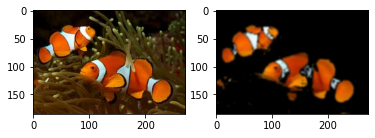

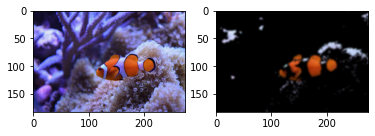

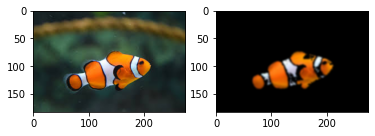

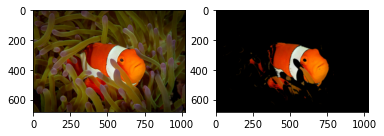

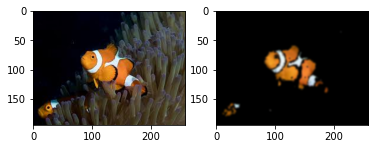

In [ ]:
results = [segment_fish(friend) for friend in nemos_friends]
for i in range(1, 6):
    plt.subplot(1, 2, 1)
    plt.imshow(nemos_friends[i])
    plt.subplot(1, 2, 2)
    plt.imshow(results[i])
    plt.show()

Podemos observar que esta segmentación generaliza bastante bien para otros casos.

# Otro ejemplo de segmentación

Al igual que hicimos con nemo, ahora buscamos segmentar, de la foto que se ve a continuación, el pajaro azul.

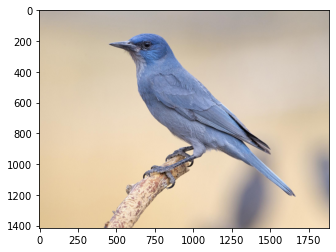

In [ ]:
bird = cv2.imread("bird.jpg")
bird = cv2.cvtColor(bird, cv2.COLOR_BGR2RGB)
plt.imshow(bird)
plt.show()

Observemos el espacio RGB y HSV de la imagen para ver en cual nos es mas favorable intentar aislar los pixeles correspondientes

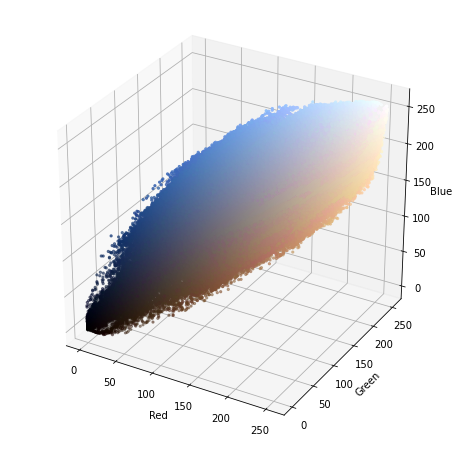

In [ ]:
r, g, b = cv2.split(bird)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")
pixel_colors = bird.reshape((np.shape(bird)[0] * np.shape(bird)[1], 3))
norm = colors.Normalize(vmin=-1.0, vmax=1.0)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(
    r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker="."
)
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

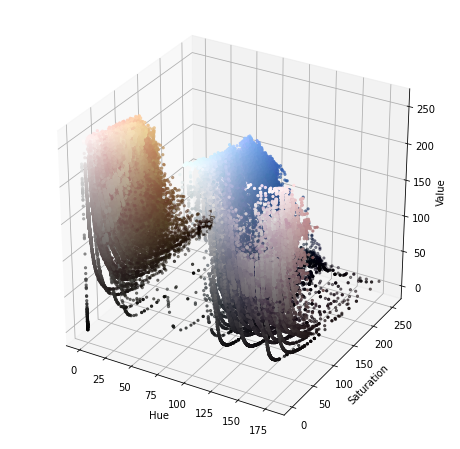

In [ ]:
hsv_bird = cv2.cvtColor(bird, cv2.COLOR_RGB2HSV)

h, s, v = cv2.split(hsv_bird)

fig = plt.figure(figsize=(8, 8))
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(
    h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker="."
)
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

En el espacio HSV, al igual que en el ejemplo de nemo, podemos observar secciones mas delimitadas donde encontramos los pixeles de color azul, es por eso que se eligió este espacio para realizar la segmentación.

A continuación buscamos los limites para armar nuestras mascaras

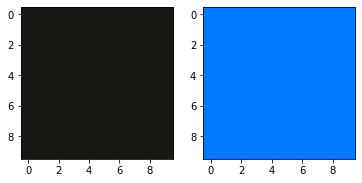

In [ ]:
dark_blue = (45, 40, 25)
light_blue = (150, 255, 255)

lw_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()

Con estos colores veamos como nos quedaría la mascara

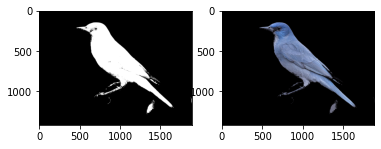

In [ ]:
mask_bird = cv2.inRange(hsv_bird, dark_blue, light_blue)
result = cv2.bitwise_and(bird, bird, mask=mask_bird)

plt.subplot(1, 2, 1)
plt.imshow(mask_bird, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

Es de esta manera que podemos obtener nuestro pajaro azul.

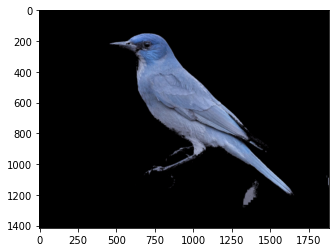

In [ ]:
blur = cv2.GaussianBlur(result, (7, 7), 0)
plt.imshow(blur)
plt.show()


Algunas observaciones:
- Se dificulto extraer el segmento de la imagen que esta por afuera del pajaro, ya que comparten colores muy similares
- No se logro obtener el mejor resutlado en cuanto a las patas

Es por esto que se indago en buscar segmentar de la imagen el tronco, a ver si mejoran los resultados

Para esto se eligieron los extremos:

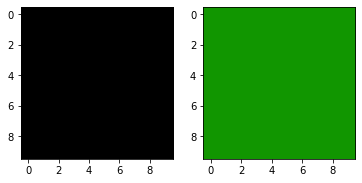

In [ ]:
light_blue = (0, 45, 0)
dark_blue = (80, 255, 150)

lw_square = np.full((10, 10, 3), light_blue, dtype=np.uint8) / 255.0
dw_square = np.full((10, 10, 3), dark_blue, dtype=np.uint8) / 255.0

plt.subplot(1, 2, 1)
plt.imshow(hsv_to_rgb(lw_square))
plt.subplot(1, 2, 2)
plt.imshow(hsv_to_rgb(dw_square))
plt.show()

Podemos ver la mascara

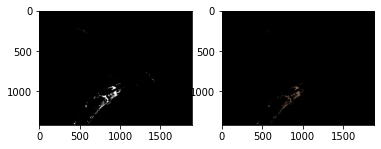

In [ ]:
mask_branch = cv2.inRange(hsv_bird, light_blue, dark_blue)
result = cv2.bitwise_and(bird, bird, mask=mask_branch)

plt.subplot(1, 2, 1)
plt.imshow(mask_branch, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

De esta manera el resultaod final, sumando las 2 mascaras, nos queda

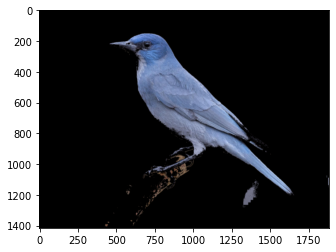

In [ ]:
mask_f = mask_bird + mask_branch
result_f = cv2.bitwise_and(bird, bird, mask=mask_f)

blur = cv2.GaussianBlur(result_f, (7, 7), 0)
plt.imshow(blur)
plt.show()